In [2]:
import helper
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib import animation

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:163: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:184: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [3]:
RULE = 30

In [4]:
pop_size = 20
grn_size=22
dev_steps = 22
num_cells = 22
geneid=1
try_seedints = [69904,149796]

all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
    start_pattern = helper.seedID2string(s, num_cells)
    start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
    targets = helper.rule2targets_wrapped_wstart(int(RULE), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    all_targs.append(targets)

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, RULE, try_seedints[0], try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, RULE, try_seedints[1], try_seedints[1])



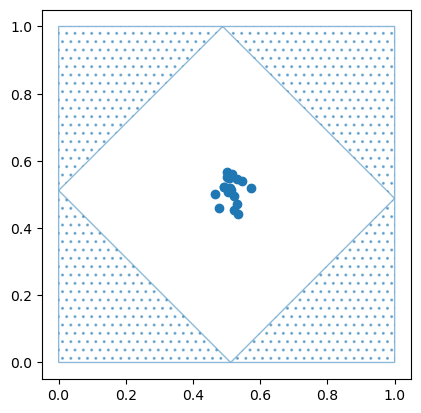

In [5]:
landmarks=helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

In [35]:
root="~/scratch/detailed_save/"
folders = ["variable","static","static"]
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300,100_000,100_000]
rules = [f"{RULE}-{RULE}", RULE, RULE]
num_repeats = 15
pop_size = 1000

all_fits = []
for g in range(len(season_lens)):
    fits=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
    fits = np.array(fits)
    num_gens = int(fits.shape[1]/2/pop_size)
    fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
    all_fits.append(fits)
all_fits=np.vstack(all_fits)
all_fits=np.reshape(all_fits, (3, num_repeats, num_gens, 2, pop_size ))
all_fits.shape

(3, 15, 9899, 2, 1000)

In [12]:
def make_restricted_plot(all_targs, num_cells, dev_steps, dot_xs, dot_ys, parent_dots, labelled=True):

    worst= -num_cells*(dev_steps+1)
    oritargs = np.array([all_targs[0],all_targs[1]])

    where_overlap = np.where(all_targs[0]==all_targs[1])
    where_no_overlap = np.where(all_targs[0]!=all_targs[1])

    bestgen=all_targs[0].copy()
    bestgen[where_no_overlap] = 0.5
    bestgen = np.expand_dims(bestgen, axis=0)

    half= int(len(where_no_overlap[0])/2)

    a = all_targs[0].copy()
    a[tuple(idx[:half] for idx in where_no_overlap)] = 0.5
    a = np.expand_dims(a, axis=0)

    b = all_targs[1].copy()
    b[tuple(idx[:half] for idx in where_no_overlap)] = 0.5
    b = np.expand_dims(b, axis=0)

    inperfa = 1 - all_targs[0].copy()
    inperfa = np.expand_dims(inperfa, axis=0)
    inperfb = 1 - all_targs[1].copy()
    inperfb = np.expand_dims(inperfb, axis=0)

    worstgen=inperfa[0].copy()
    worstgen[where_no_overlap] = 0.5
    worstgen = np.expand_dims(worstgen, axis=0)

    c= all_targs[0].copy()
    c[where_overlap] = 0.5
    c = np.expand_dims(c, axis=0)

    d= all_targs[1].copy()
    d[where_overlap] = 0.5
    d = np.expand_dims(d, axis=0)

    labels = ["A", "B", "Overlap good, rest 0.5", "Overlap good, rest/2 0.5, A", "Overlap good, rest/2 0.5, B", "A inverse","B inverse", "Overlap inverse, rest 0.5"]
    labels.append("A but overlap 0.5")
    labels.append("B but overlap 0.5")

    pop = np.concatenate((oritargs, bestgen,a,b,inperfa,inperfb,worstgen,c,d), axis=0) #0,1, 4,5

    fitnesses1 = -np.abs(pop - all_targs[0]).sum(axis=1).sum(axis=1)
    fitnesses1=1-(fitnesses1/worst) #0-1 scaling
    fitnesses2 = -np.abs(pop - all_targs[1]).sum(axis=1).sum(axis=1)
    fitnesses2=1-(fitnesses2/worst) #0-1 scaling

    pop_df = pd.DataFrame()
    pop_df["x"]=fitnesses1
    pop_df["y"]=fitnesses2
    xs=fitnesses1
    ys=fitnesses2

    if labelled:
        labels = list(zip(fitnesses1,fitnesses2))
        plt.scatter(pop_df["x"], pop_df["y"])
        for i, label in enumerate(labels): 
            plt.text(
                xs[i],
                ys[i],
                label,
                ha="center",
                va="bottom",
                color="black",
            )

    plt.scatter(dot_xs, dot_ys, s=3, c="black", label="children")
    sns.scatterplot(data=parent_dots, x='x', y='y',color='red', s=3, label="parents")

    sns.set_style("whitegrid")

    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)

    myhatch='..'
    mycolor="C0"
    triangle = Polygon([[1,1], pop_df.iloc[0], pop_df.iloc[1]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
    plt.gca().add_patch(triangle)
    triangle = Polygon([[0,0], pop_df.iloc[5], pop_df.iloc[6]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
    plt.gca().add_patch(triangle)
    triangle = Polygon([[0,1], pop_df.iloc[1], pop_df.iloc[5]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
    plt.gca().add_patch(triangle)
    triangle = Polygon([[1,0], pop_df.iloc[0], pop_df.iloc[6]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
    plt.gca().add_patch(triangle)

    plt.plot([0, 1], [0, 1], '--', linewidth = 1, color="gray")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

    return pop_df

In [ ]:
#NOTE: for static envs, fitnesses 1 is always the env they were evaluated on 
# (as opposed to fitnesses 2 being the relevant one when testing environment 1)

repid=1

check_freq=300
pattern = [0] * check_freq + [1] * check_freq
switching_list = np.array(pattern * 100)

a=list(range(9899))
int_gens=np.array(a[check_freq-1::check_freq])
int_gens2 = int_gens - 296
int_gens = sorted(np.concatenate((int_gens, int_gens2)))
curr_list = switching_list[int_gens]
print(int_gens)
print(curr_list)
#int_gens=[1999]

exp_id = 1

for idx, i in enumerate(int_gens):
    print(i)
    fitnesses1=all_fits[exp_id][repid][i][0]
    fitnesses2=all_fits[exp_id][repid][i][1]
        
    pop_df_prev = pd.DataFrame()
    pop_df_prev["x"]=all_fits[exp_id][repid][i-1,0,:]
    pop_df_prev["y"]=all_fits[exp_id][repid][i-1,1,:]

    if curr_list[idx] == 0:
        parent_dots=pop_df_prev.sort_values(by="x",ascending=False).head(100)
    else:
        parent_dots=pop_df_prev.sort_values(by="y",ascending=False).head(100)

    make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, parent_dots, labelled=False)


# GENERALISM

In [20]:
landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])
conz_BH, conz_BH_mean = helper.calc_conz_BH(all_fits, landmarks_list)

/tmp/ipykernel_24092/1706561750.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])


In [22]:
conz_BH_mean.shape

(3, 15, 9899)

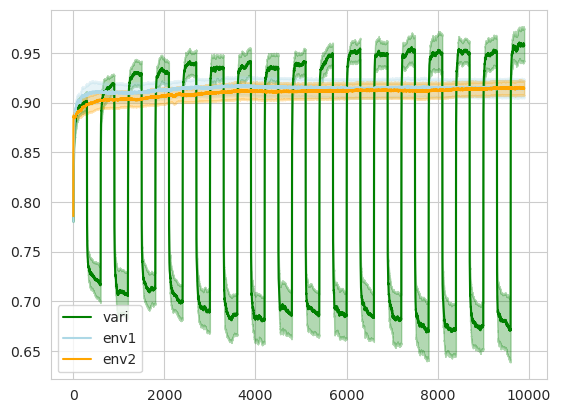

In [23]:
num_reps = 15
z_value = 1.96  # For a 95% confidence interval
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]

for i in range(3):
    mean1 = conz_BH_mean[i,:,:].mean(axis = 0)
    stderr1 = np.std(conz_BH_mean[i,:,:], axis=0) / np.sqrt(num_reps)
    ci_upper = mean1 + z_value * stderr1
    ci_lower = mean1 - z_value * stderr1
    plt.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[i])
    plt.plot(mean1, "-", label= labels[i], color=colors[i])
plt.legend()

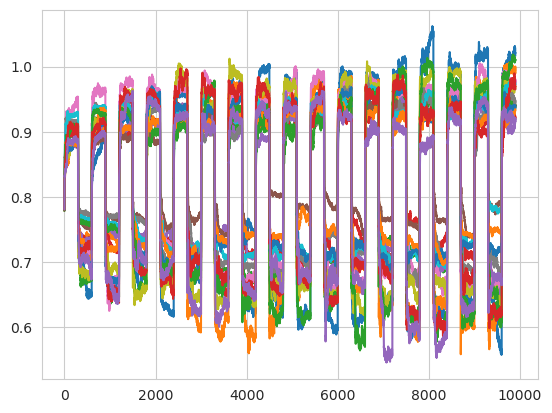

In [36]:
for i in range(num_repeats):
    plt.plot(conz_BH_mean[0,i,:])

In [32]:
import numpy as np
conz_BH_mean.shape

(3, 15, 9899)

0 8081
1.0615866148593769


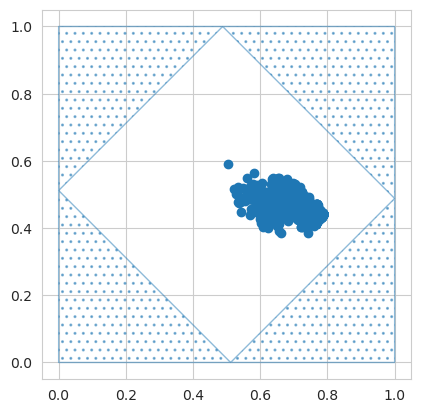

,x,y
0,1.000000,0.488142
1,0.488142,1.000000
2,0.744071,0.744071
3,0.872530,0.615613
4,0.615613,0.872530
5,0.000000,0.511858
6,0.511858,0.000000
7,0.255929,0.255929
8,0.755929,0.244071
9,0.244071,0.755929


In [33]:
exp_id = 0 #variable
highest_gen_rep, highest_gen_gen = np.unravel_index(np.argmax(conz_BH_mean[exp_id,:,:]), conz_BH_mean[0].shape)
print(highest_gen_rep, highest_gen_gen)
print(conz_BH_mean[exp_id,highest_gen_rep, highest_gen_gen])
fitnesses1=all_fits[exp_id, highest_gen_rep, highest_gen_gen][0]
fitnesses2=all_fits[exp_id, highest_gen_rep, highest_gen_gen][1]

helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

### Now to check for generalist phenotypes

In [6]:
# Parameters
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1 #which gene was used to get fitness
root="~/scratch/detailed_save/"
folders = ["variable","static","static"]
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300]# 100_000,100_000]
rules = [f"{RULE}-{RULE}", RULE, RULE]
num_repeats = 15

all_grns = []
for g in range(len(season_lens)):
    grns=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_best_grn.txt")) for i in range(num_repeats)]
    grns = np.array(grns)
    num_grns = int(grns.shape[1]/(grn_size+2)/grn_size)
    grns = grns.reshape(num_repeats,num_grns,grn_size+2,grn_size) #repeats, gens, weights1, weights2
    tmp=np.reshape(grns, (num_repeats,num_grns,(grn_size+2)*grn_size))
    all_grns.append(tmp)
all_grns=np.vstack(all_grns)
#all_grns = np.reshape(all_grns, (num_repeats * num_gens, grn_size+2, grn_size))
print(all_grns.shape)


(15, 9899, 528)


In [9]:
num_gens = 9899
gens=list(range(num_gens))
season_len = 300
n_seasons = int(np.floor(num_gens/season_len))
chunked_gens = np.array([gens[i*300:(i+1)*300] for i in range(n_seasons)])
s1, s2 = chunked_gens[0::2], chunked_gens[1::2]
s1 = np.array([x for xs in s1 for x in xs])
s2 = np.array([x for xs in s2 for x in xs])

In [29]:
#NOTE: CAN EASILY MODIFY TO CHECK FOR EACH BEST GRN HOW GOOD IT WOULD DO GIVEN THE OTHER INPUT
#ONLY FOR VARIABLE EXPERIMENTS
best_fits = np.zeros((num_repeats,len(s1)+len(s2),2))
best_phenos = np.zeros((num_repeats,len(s1)+len(s2),dev_steps+1,num_cells))
#in season 1
for r in range(num_repeats):
    temp_grn = all_grns[r,s1,:]
    temp_grn = np.reshape(temp_grn, (len(s1), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=69904, seed_int_dev = 69904)
    best_fits[r, s1, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=149796, seed_int_dev = 69904)
    best_fits[r, s1, 1] = fitnesses #compared to the alternative target
    print(phenos.shape)
    best_phenos[r, s1, :, :] = phenos
#in season 2
for r in range(num_repeats):
    temp_grn = all_grns[r,s2,:]
    temp_grn = np.reshape(temp_grn, (len(s2), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=149796, seed_int_dev = 149796)
    best_fits[r, s2, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=69904, seed_int_dev = 149796)
    best_fits[r, s2, 1] = fitnesses #compared to the alternative target
    best_phenos[r, s2, :, :] = phenos
best_fits = np.array(best_fits) #num repeats, len(s1)+len(s2), fit1, fit2
best_fits2=best_fits[np.newaxis, :]
best_fits3=np.expand_dims(best_fits2, axis=-1) #same shape as all_fits but just for variable and 1 value per generation
best_fits3.shape

(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)


(1, 15, 9600, 2, 1)

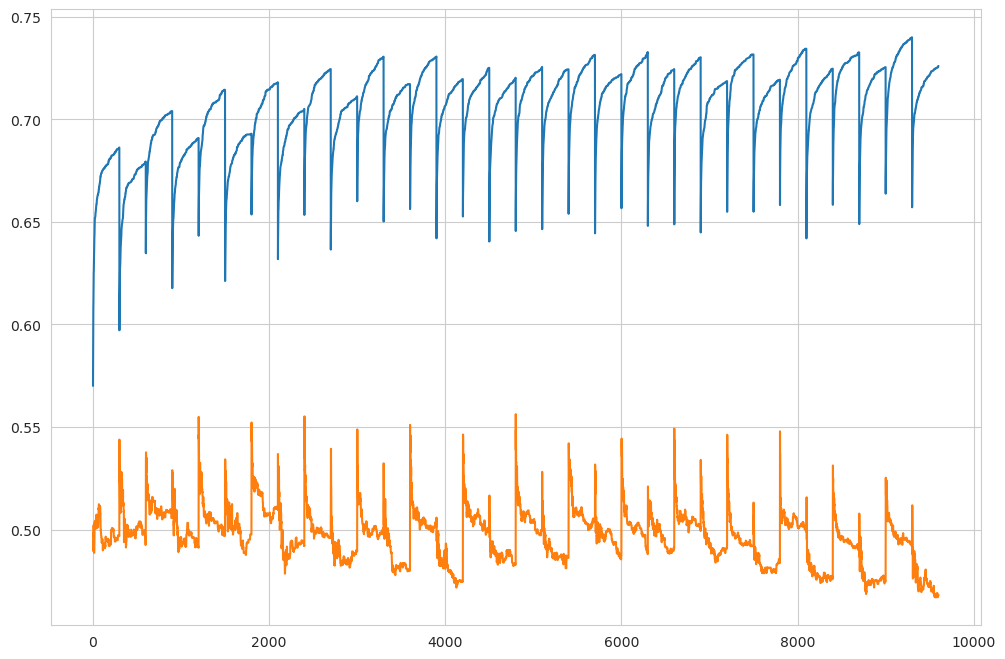

In [30]:
fig = plt.figure(figsize=(12,8))
plt.plot(best_fits3[0,:,:,0,0].mean(axis = 0))
plt.plot(best_fits3[0,:,:,1,0].mean(axis = 0))

In [12]:
landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])


/tmp/ipykernel_17622/867190813.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])


In [13]:
best_conz_BH, _ = helper.calc_conz_BH(best_fits3, landmarks_list)
print(best_conz_BH.shape)
flat_index = np.argmax(best_conz_BH)
# Convert the flat index to coordinates in the original shape
coordinates = np.unravel_index(flat_index, best_conz_BH.shape)
coordinates

(1, 15, 9600, 1)


(0, 0, 8092, 0)

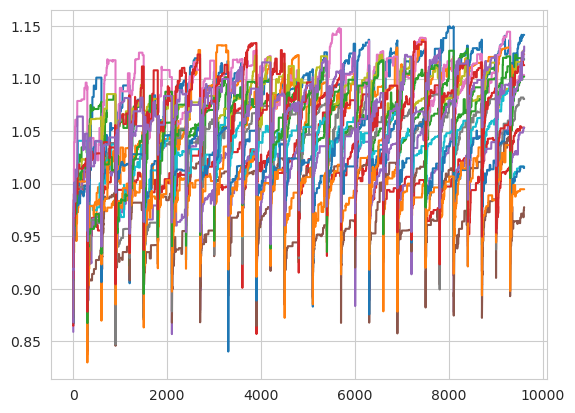

In [14]:
for i in range(num_repeats):
    plt.plot(best_conz_BH[0,i,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


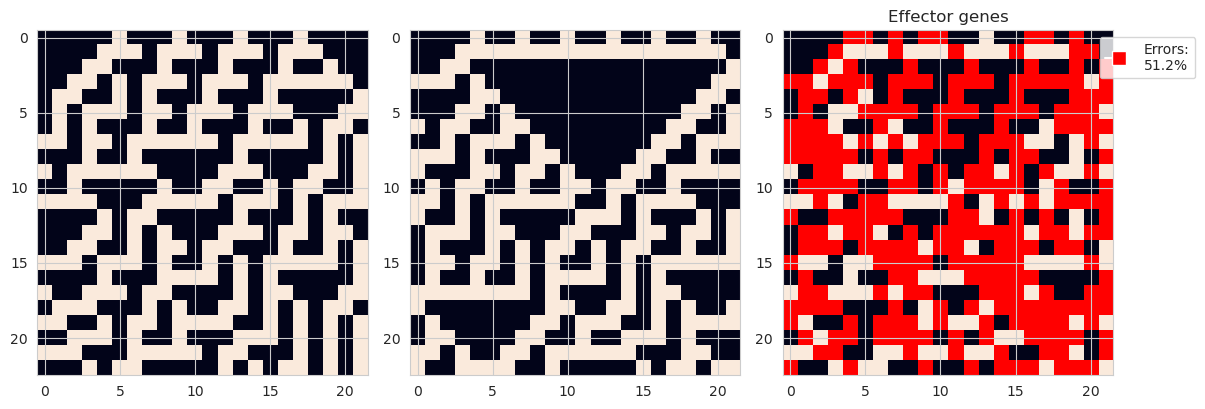

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
#Plot best phenotype
axs[0].imshow(all_targs[0])
#Plot target
axs[1].imshow(all_targs[1])
#Plot difference
helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])

plt.tight_layout()
plt.show()

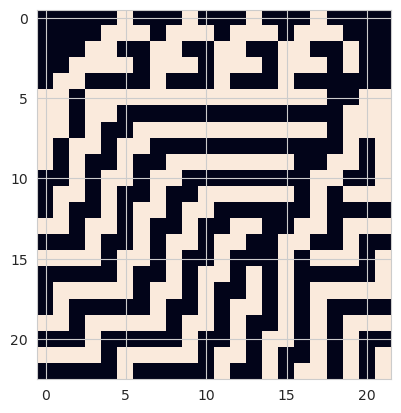

In [16]:
plt.imshow(best_phenos[coordinates[1], coordinates[2],:,:])

In [22]:
all_grns.shape

(15, 9899, 528)

In [17]:
#NOTE: CAN EASILY MODIFY TO CHECK FOR EACH BEST GRN HOW GOOD IT WOULD DO GIVEN THE OTHER INPUT --> this is it
#ONLY FOR VARIABLE EXPERIMENTS
best_fits = np.zeros((num_repeats,len(s1)+len(s2),2))
best_phenos = np.zeros((num_repeats,len(s1)+len(s2),dev_steps+1,num_cells))
#in season 1
for r in range(num_repeats):
    temp_grn = all_grns[r,s1,:]
    temp_grn = np.reshape(temp_grn, (len(s1), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=69904, seed_int_dev = 69904)
    best_fits[r, s1, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=149796, seed_int_dev = 149796)
    best_fits[r, s1, 1] = fitnesses #compared to the alternative target
    print(phenos.shape)
    best_phenos[r, s1, :, :] = phenos
#in season 2
for r in range(num_repeats):
    temp_grn = all_grns[r,s2,:]
    temp_grn = np.reshape(temp_grn, (len(s2), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=149796, seed_int_dev = 149796)
    best_fits[r, s2, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, RULE, seed_int_target=69904, seed_int_dev = 69904)
    best_fits[r, s2, 1] = fitnesses #compared to the alternative target
    best_phenos[r, s2, :, :] = phenos
best_fits = np.array(best_fits) #num repeats, len(s1)+len(s2), fit1, fit2
best_fits2=best_fits[np.newaxis, :]
best_fits3=np.expand_dims(best_fits2, axis=-1) #same shape as all_fits but just for variable and 1 value per generation
best_fits3.shape

(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)
(4800, 23, 22)


(1, 15, 9600, 2, 1)

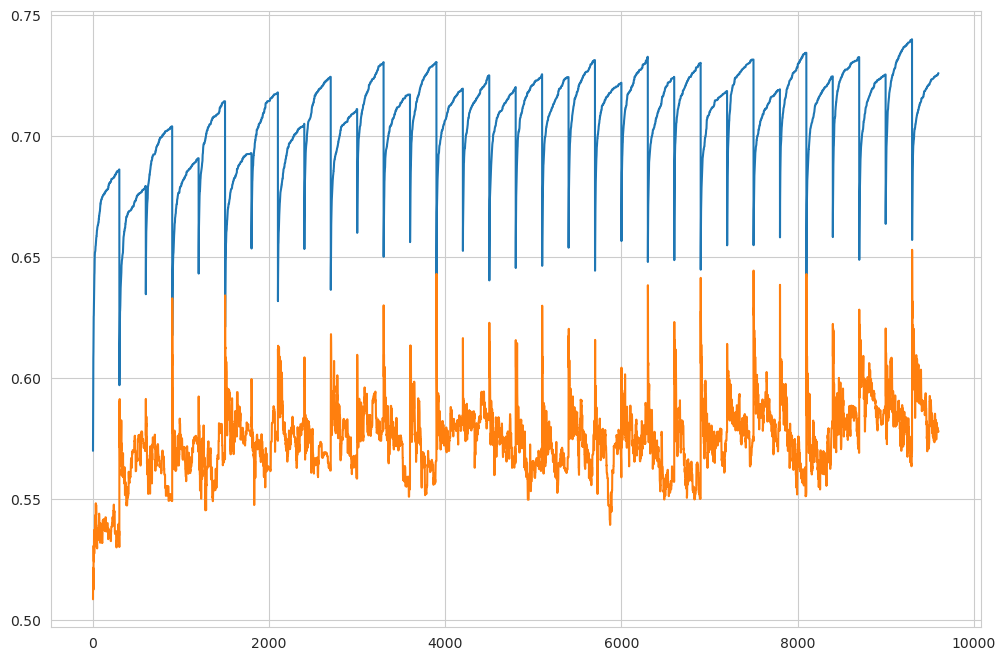

In [28]:
#Darker = newer, best GRN fitness in each generation, given that judging alternative environment happens with alternative input!
#cmaps=["Reds", "Blues", "Greens"]

#for r in range(num_repeats):
#    color_map = plt.get_cmap(cmaps[r])
#    for g in range(best_fits3.shape[2]):
#        color = color_map(g / (num_gens - 1)+0.3)
#        plt.scatter(best_fits3[0,r,g,0,0],best_fits3[0,r,g,1,0],color=color)

fig = plt.figure(figsize=(12,8))
plt.plot(best_fits3[0,:,:,0,0].mean(axis = 0))
plt.plot(best_fits3[0,:,:,1,0].mean(axis = 0))

# Diversifying

In [ ]:
stds.append(np.std(both_fits[:,0,:],axis=1))

In [33]:
root="~/scratch/detailed_save/"
folders = ["variable","static","static"]
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300,100_000,100_000]
rules = [f"{RULE}-{RULE}", RULE, RULE]
num_repeats = 15
pop_size = 1000


all_edges = []
for g in range(len(season_lens)):
    edges=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_edges.txt")) for i in range(num_repeats)]
    edges = np.array(edges).astype(int) 
    num_generations=int(edges.shape[1]/4/pop_size)
    print(edges.shape, num_generations)
    edges = edges.reshape(num_repeats, num_generations*pop_size, 2, 2)
    all_edges.append(edges)
all_edges=np.vstack(all_edges)
all_edges=np.reshape(all_edges, (3, num_repeats, num_generations*pop_size, 2, 2 ))
all_edges.shape

(15, 39596000) 9899
(15, 39596000) 9899
(15, 39596000) 9899


(3, 15, 9899000, 2, 2)

In [36]:
from tqdm import trange

kid_fits = np.zeros((3,num_repeats,num_generations-1,2, 100,10))
for e in range(3):
    for rep in range(num_repeats):
        for g in trange(num_generations-1): #last gen has kids but no fitnesses computed
            start = g*pop_size
            stop = g*pop_size + pop_size
            a = all_edges[e,rep,start:stop, :, :] #first generation, gen 0
            unique_first_positions, inverse_indices = np.unique(a[:, 0], axis=0, return_inverse=True)
            #print(unique_first_positions.shape) #100, parents
            #print(inverse_indices.shape) #1000, kids, including surviving parents
            b = np.array([a[:, 1][inverse_indices == i] for i in range(len(unique_first_positions))]) #for each parent, 10 kids, 2d id
            b = b[:,:,1] #only second id is interesting
            b_flattened = b.reshape(pop_size)
            b_fits = all_fits[e,rep,g+1,:,:][:,b_flattened] #have to be looking 1 gen down
            b_fits = b_fits.reshape(2, 100, 10) #the 2 fitness values, num parents, num kids
            #print(b_fits[1,3,5]) #fitness2 of the sixth kid of the fourth parent
            #print(all_fits[0,0,1,1,777]) #fitness2 of the 777th individual in the population in the second generation
            kid_fits[e,rep,g,:,:,:] = b_fits

100%|██████████| 9898/9898 [00:10<00:00, 941.76it/s] 


In [37]:
kid_fits.shape #experiment, rep, generation, 2 fits, 100 parents, 10 kids

(3, 15, 9898, 2, 100, 10)

In [38]:
div_BH, div_BH_mean = helper.calc_div_BH(kid_fits, landmarks)
div_BH.shape

(3, 15, 9898, 100)

In [39]:
div_BH_mean.shape

(3, 15, 9898)

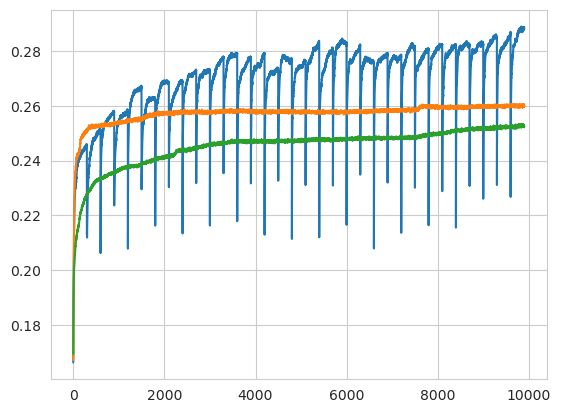

In [40]:
for i in range(3):
    plt.plot(div_BH_mean[i,:,:].mean(axis=0)) #NOTE: can do the 3 line plots with this list too!

In [41]:
flat_index = np.argmax(div_BH)
# Convert the flat index to coordinates in the original shape
coordinates = np.unravel_index(flat_index, div_BH.shape)
coordinates #experiment, rep, gen, parent

(0, 0, 8080, 10)

In [45]:
all_fits.shape


(3, 15, 9899, 2, 1000)

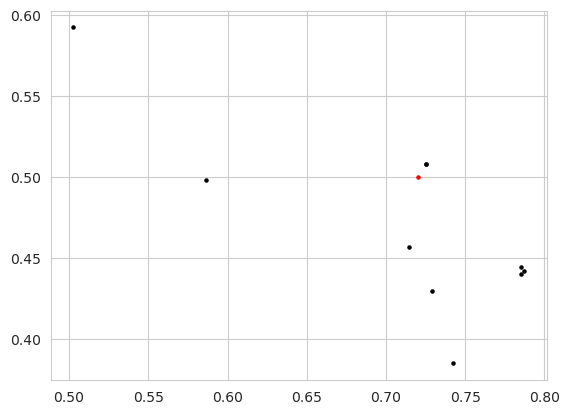

In [47]:
fitnesses1 = kid_fits[coordinates[0],coordinates[1],coordinates[2],0,coordinates[3],:]
fitnesses2 = kid_fits[coordinates[0],coordinates[1],coordinates[2],1,coordinates[3],:]
plt.scatter(fitnesses1, fitnesses2, s = 5, c="black")
pf1 = all_fits[coordinates[0],coordinates[1],coordinates[2],0,coordinates[3]]
pf2 = all_fits[coordinates[0],coordinates[1],coordinates[2],1,coordinates[3]]
plt.scatter(pf1, pf2, s = 5, c= "red")
#helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

In [ ]:
flat_index = np.argmin(div_BH)
# Convert the flat index to coordinates in the original shape
coordinates = np.unravel_index(flat_index, div_BH.shape)
print(coordinates) #experiment, rep, gen, parent

for i in range(100):
    rand_coordinate = [np.random.choice([0,1,2]),np.random.choice([0,1]),np.random.choice(list(range(1800))),np.random.choice(list(range(100)))]
    coordinates = rand_coordinate
    fitnesses1 = kid_fits[coordinates[0],coordinates[1],coordinates[2],0,coordinates[3],:]
    fitnesses2 = kid_fits[coordinates[0],coordinates[1],coordinates[2],1,coordinates[3],:]
    helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)